##### 作成:脳科学若手の会 佐藤元重
##### 質問：コメントはこちらまで motoshige-sato702@g.ecc.u-tokyo.ac.jp

# ソースコードとデータセットのメタ情報をダウンロード

In [1]:
!git clone https://github.com/cycentum/cascaded-am-tuning-for-sound-recognition.git
!pip install soundfile
%cd cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/
%mkdir cascaded-am-tuning-for-sound-recognition/
%cd cascaded-am-tuning-for-sound-recognition/
!wget --content-disposition https://ndownloader.figshare.com/files/14738297
!wget --content-disposition https://ndownloader.figshare.com/files/14738300
!wget --content-disposition https://ndownloader.figshare.com/files/14738303
!sudo apt install p7zip-full
!7z x am-meta-analysis.7z
!7z x ESC50.7z
!7z x TIMIT.7z

Cloning into 'cascaded-am-tuning-for-sound-recognition'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 97 (delta 10), reused 6 (delta 0), pack-reused 69
Unpacking objects: 100% (97/97), done.
/content/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition
/content/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition
--2021-03-14 04:36:43--  https://ndownloader.figshare.com/files/14738297
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 34.240.131.233, 108.128.230.190, 52.209.254.58, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|34.240.131.233|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/14738297/ESC50.7z [following]
--2021-03-14 04:36:43--  https://s3-eu-west-1.am

# 諸々のライブラリをインポート
##### ※メモリがクラッシュした時のヒント
##### たいていストレージが消えているわけではありません．以下の二つのセルから実行すればよいです．

In [2]:
# ディレクトリの名前が重複している個所があるので注意．
ROOT_DIR = '/content/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition'
%cd $ROOT_DIR
!ls

/content/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition
cascaded-am-tuning-for-sound-recognition  plot_bmf_ucf_timit.py
draw_mtf_esc50.py			  recording_esc50.py
draw_mtf_timit.py			  recording_timit.py
draw_similarity_esc50.py		  train_eval_esc50.py
draw_similarity_timit.py		  train_eval_timit.py
model					  training
physiology				  utils
plot_bmf_ucf_esc50.py


In [3]:
from numpy import newaxis, float32, float64, int32, int64, int16, int8, uint8, uint32
from chainer import Variable, serializers, functions, optimizers
import chainer
import numpy as np
import cupy
import math
import IPython.display
import soundfile
from collections import defaultdict, Counter
import itertools
from pathlib import Path
import pickle
import os

from model.architecture import sampleArchitecture, architectureStr
from model.net import totalInputLength, Net
from training.esc50.train_eval import findNumEpoch, train, evaluate
from training.esc50.load_data import loadWaves, readInfos, fade
from utils.utils import localTimeStr, readTable
from physiology.recording import *
from model.architecture import readArchitecture

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from PIL import Image


# Architecture
##### 層の数（numLayer）フィルターの（チャンネル数numChannel，受容野の長さinputLen，フィルターの長さfilterLen）を決定する．
##### dilation rate = (inputLen - 1) // (filterLen - 1)であり，割り切れるように自動で調整する．
##### $2 \leqq filterLen \leqq filterLenUpper$という拘束条件のもと決まる．
##### padding = 0なので各層inputLen - 1ずつ音波の長さが減少していく．最終層では長さが1になる．
##### ネットワーク構築時は最終層の後にチャンネルごとの特徴量を組み合わせてクラス分類を行うFC層を最後に加える．
<img src="https://drive.google.com/uc?export=view&id=1nRbnEQ6WKRhb06z2yqfaOEuQ58Fg5LRT" alt="Drawing" width="700">


##### 【課題設定のヒント】
論文では受容野の長さやフィルターの長さをランダムにしていますが，均等にしたり短調増加（減少）にしたらどうなるか？など

In [4]:
#sample architecture
numLayer=13
totalInputLenUpper=8192
numChannel=128
filterLenUpper=8
architecture=sampleArchitecture(numLayer, totalInputLenUpper, numChannel, filterLenUpper)
print("Architecture")
print("N_ch", "inputLen", "filterLen")
architecture

Architecture
N_ch inputLen filterLen


[(128, 667, 7),
 (128, 401, 5),
 (128, 754, 4),
 (128, 1421, 6),
 (128, 861, 5),
 (128, 736, 8),
 (128, 506, 6),
 (128, 134, 8),
 (128, 1039, 7),
 (128, 391, 6),
 (128, 391, 6),
 (128, 862, 2),
 (128, 16, 4)]

In [5]:
from training.esc50.load_data import getLabels 
labels=getLabels()
numLabel=len(labels)
numLabel #ESC50なら18，TIMITなら39

18

In [6]:
# 128個の特徴量から各クラスらしさを予測するFC層を最終層に加えて未学習のDNNを作る
net=Net(numLabel, architecture, functions.elu) # クラス数，architecture，活性化関数の種類を入れる
opt=optimizers.Adam(1e-4) # 最適化アルゴリズムを設定．Adamが無難だが色々変えてみてもよい
opt.setup(net)
gpu_id = 0
if gpu_id>=0: net.to_gpu(gpu_id)

# 試しにノイズをDNNに入力して処理過程の形を確認．
1. 次元目：入力波形数
2. 次元目：特徴抽出器であるフィルタ数
3. 次元目：各タイムステップ数
4. 次元目：気にしなくてよい．Conv1DよりもConv2Dのほうが計算が早いため，Conv2Dを用いており，画像用の形式に合わせている．

##### 最後の出力(16, 18, 1, 1)で16個分の波形に対して，18種類の各ラベルらしさ（≒確率）が出力される．

In [ ]:
b_size = 16 # 試しに入力してみるノイズの数
inputLength = np.array([i[1] - 1 for i in architecture]).sum() + 1
sample_data = cupy.random.rand(b_size,1,inputLength,1,dtype=float32)
layers = [net.c0, net.c1, net.c2, net.c3,
          net.c4, net.c5, net.c6, net.c7,
          net.c8, net.c9, net.c10, net.c11,
          net.c12, net.full]
print('input shape')
print(sample_data.shape)
print('\noutput shape')
x = sample_data
for l in range(14):
  for i in range(l+1):
    x = layers[i](x)
  print(x.shape)
  x = sample_data

input shape
(16, 1, 8161, 1)

output shape
(16, 128, 6961, 1)
(16, 128, 6561, 1)
(16, 128, 5733, 1)
(16, 128, 5455, 1)
(16, 128, 5154, 1)
(16, 128, 4992, 1)
(16, 128, 4929, 1)
(16, 128, 4329, 1)
(16, 128, 3514, 1)
(16, 128, 2866, 1)
(16, 128, 2006, 1)
(16, 128, 1126, 1)
(16, 128, 1, 1)
(16, 18, 1, 1)


### 学習させるデータをダウンロード
##### ESC50：犬の鳴き声や騒音など自然音のデータセット．https://github.com/karolpiczak/ESC-50
##### TIMIT：人のスピーチのデータセット．男女含むアメリカ英語．https://catalog.ldc.upenn.edu/LDC93S1

In [ ]:
%cd $ROOT_DIR/cascaded-am-tuning-for-sound-recognition/ESC50
!wget --save-cookies cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CQAMfRmCPsLUlhN4FJKIKdm-eQ5O0uZR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/Code: \1\n/p'

/content/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/ESC50
--2021-03-12 22:30:22--  https://docs.google.com/uc?export=download&id=1CQAMfRmCPsLUlhN4FJKIKdm-eQ5O0uZR
Resolving docs.google.com (docs.google.com)... 74.125.195.102, 74.125.195.100, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

-                       [ <=>                ]   3.21K  --.-KB/s    in 0s      

2021-03-12 22:30:22 (67.7 MB/s) - written to stdout [3287]

Code: DGnr


In [ ]:
passwd = 'DGnr' # 出てきた4文字列をコピペ
!wget --load-cookies cookies.txt $'https://docs.google.com/uc?export=download&confirm='$passwd$'&id=1CQAMfRmCPsLUlhN4FJKIKdm-eQ5O0uZR'
!unzip $'uc?export=download&confirm='$passwd$'&id=1CQAMfRmCPsLUlhN4FJKIKdm-eQ5O0uZR'
%rm $'uc?export=download&confirm='$passwd$'&id=1CQAMfRmCPsLUlhN4FJKIKdm-eQ5O0uZR'

--2021-03-12 22:30:29--  https://docs.google.com/uc?export=download&confirm=DGnr&id=1CQAMfRmCPsLUlhN4FJKIKdm-eQ5O0uZR
Resolving docs.google.com (docs.google.com)... 74.125.195.100, 74.125.195.113, 74.125.195.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-94-docs.googleusercontent.com/docs/securesc/naj9k2iu58kt2d8tgfdmtem1pmf800iv/ta1laqdehgc4vmgvo3t3r6ch2lhher54/1615588200000/01444885733146711118/16858128339031022581Z/1CQAMfRmCPsLUlhN4FJKIKdm-eQ5O0uZR?e=download [following]
--2021-03-12 22:30:30--  https://doc-0o-94-docs.googleusercontent.com/docs/securesc/naj9k2iu58kt2d8tgfdmtem1pmf800iv/ta1laqdehgc4vmgvo3t3r6ch2lhher54/1615588200000/01444885733146711118/16858128339031022581Z/1CQAMfRmCPsLUlhN4FJKIKdm-eQ5O0uZR?e=download
Resolving doc-0o-94-docs.googleusercontent.com (doc-0o-94-docs.googleusercontent.com)... 74.125.199.132, 2607:f8b0:400e:c02::84
Connecting

In [ ]:
%cd $ROOT_DIR/cascaded-am-tuning-for-sound-recognition/TIMIT
!wget --save-cookies cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=10Boxn-iwFdLKK2yAIAtUR3uNjTWcoJ7w' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/Code: \1\n/p'

/content/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/TIMIT
--2021-03-12 22:30:37--  https://docs.google.com/uc?export=download&id=10Boxn-iwFdLKK2yAIAtUR3uNjTWcoJ7w
Resolving docs.google.com (docs.google.com)... 74.125.195.102, 74.125.195.100, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

-                       [ <=>                ]   3.22K  --.-KB/s    in 0s      

2021-03-12 22:30:37 (74.7 MB/s) - written to stdout [3294]

Code: t4R0


In [ ]:
passwd = 't4R0' # 出てきた4文字列をコピペ
!wget --load-cookies cookies.txt $'https://docs.google.com/uc?export=download&confirm='$passwd$'&id=10Boxn-iwFdLKK2yAIAtUR3uNjTWcoJ7w'
!tar -xzvf $'uc?export=download&confirm='$passwd$'&id=10Boxn-iwFdLKK2yAIAtUR3uNjTWcoJ7w'
%mv timit/TIMIT ./
%rm $'uc?export=download&confirm='$passwd$'&id=10Boxn-iwFdLKK2yAIAtUR3uNjTWcoJ7w'
%cd $ROOT_DIR

ストリーミング出力は最後の 5000 行に切り捨てられました。
timit/TIMIT/TEST/DR5/MRWS1/SI1496.WRD
timit/TIMIT/TEST/DR5/MRWS1/SI500.PHN
timit/TIMIT/TEST/DR5/MRWS1/SI500.TXT
timit/TIMIT/TEST/DR5/MRWS1/SI500.WAV
timit/TIMIT/TEST/DR5/MRWS1/SI500.WRD
timit/TIMIT/TEST/DR5/MRWS1/SX140.PHN
timit/TIMIT/TEST/DR5/MRWS1/SX140.TXT
timit/TIMIT/TEST/DR5/MRWS1/SX140.WAV
timit/TIMIT/TEST/DR5/MRWS1/SX140.WRD
timit/TIMIT/TEST/DR5/MRWS1/SX230.PHN
timit/TIMIT/TEST/DR5/MRWS1/SX230.TXT
timit/TIMIT/TEST/DR5/MRWS1/SX230.WAV
timit/TIMIT/TEST/DR5/MRWS1/SX230.WRD
timit/TIMIT/TEST/DR5/MRWS1/SX320.PHN
timit/TIMIT/TEST/DR5/MRWS1/SX320.TXT
timit/TIMIT/TEST/DR5/MRWS1/SX320.WAV
timit/TIMIT/TEST/DR5/MRWS1/SX320.WRD
timit/TIMIT/TEST/DR5/MRWS1/SX410.PHN
timit/TIMIT/TEST/DR5/MRWS1/SX410.TXT
timit/TIMIT/TEST/DR5/MRWS1/SX410.WAV
timit/TIMIT/TEST/DR5/MRWS1/SX410.WRD
timit/TIMIT/TEST/DR5/MRWS1/SX50.PHN
timit/TIMIT/TEST/DR5/MRWS1/SX50.TXT
timit/TIMIT/TEST/DR5/MRWS1/SX50.WAV
timit/TIMIT/TEST/DR5/MRWS1/SX50.WRD
timit/TIMIT/TEST/DR5/MRRK0
timit/TIMIT/TEST/DR

In [ ]:
# 犬の鳴き声のデータを読み込む
wave,fs = soundfile.read(ROOT_DIR + "/cascaded-am-tuning-for-sound-recognition/ESC50/ESC-50/101 - Dog/1-100032-A.ogg", dtype=float32)
IPython.display.Audio(wave, rate=fs) #waveは波形，fsはサンプリング周波数（44100 Hz）

In [ ]:
# 人のスピーチを読み込む
wave, fs = soundfile.read(ROOT_DIR + "/cascaded-am-tuning-for-sound-recognition/TIMIT/TIMIT/TRAIN/DR1/FCJF0/SX397.WAV", dtype=float32)
text=readTable(ROOT_DIR+"/cascaded-am-tuning-for-sound-recognition/TIMIT/TIMIT/TRAIN/DR1/FCJF0/SX397.PHN", " ")
IPython.display.Audio(wave, rate=fs) #waveは波形，fsはサンプリング周波数（16000 Hz）

In [ ]:
# 話していた文の各音素とそのタイミング
text

[['0', '2240', 'h#'],
 ['2240', '2940', 't'],
 ['2940', '4469', 'ih'],
 ['4469', '5540', 'm'],
 ['5540', '5860', 'tcl'],
 ['5860', '6570', 't'],
 ['6570', '8211', 'ey'],
 ['8211', '8610', 'kcl'],
 ['8610', '11112', 'sh'],
 ['11112', '12732', 'iy'],
 ['12732', '13785', 'l'],
 ['13785', '14707', 'ih'],
 ['14707', '15590', 'tcl'],
 ['15590', '15791', 't'],
 ['15791', '18882', 's'],
 ['18882', '19735', 'ix'],
 ['19735', '21184', 'm'],
 ['21184', '23071', 'uw'],
 ['23071', '24104', 'v'],
 ['24104', '25265', 'ix'],
 ['25265', '26402', 'z'],
 ['26402', '26736', 'tcl'],
 ['26736', '27800', 't'],
 ['27800', '28466', 'w'],
 ['28466', '29800', 'ay'],
 ['29800', '31210', 's'],
 ['31210', '31791', 'ax'],
 ['31791', '33131', 'w'],
 ['33131', '35080', 'iy'],
 ['35080', '36620', 'kcl'],
 ['36620', '37180', 'k'],
 ['37180', '39120', 'h#']]

# モデルの学習

### その前に解析結果を自身のGoogle Driveに保存する設定
##### Google Colaboratoryは接続が切れてしまうとデータが消えるのでデータ保存のためにドライブをマウントする．
##### 表示されたURLを開き，トークンをコピペしてEnter

In [16]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [17]:
#自分のGoogle Drive直下にSpcamp21>Wightsフォルダが作成され，未学習のDNNの重みがnaive.h5として保存される．
SAVE_DIR = './gdrive/MyDrive/Spcamp21'
if not os.path.isdir(SAVE_DIR):
  os.makedirs(SAVE_DIR)
UNTR_DIR = SAVE_DIR + '/Untrained'
if not os.path.isdir(UNTR_DIR):
  os.makedirs(UNTR_DIR)
serializers.save_hdf5(UNTR_DIR + "/naive.h5", net) #file名を付ける

In [ ]:
# 以下の二つに関しては学習に用いるデータ数をラベルごとにそろえる，最大精度の学習回数での学習を行うなどの工夫がされている．
#!python train_eval_esc50.py
!python train_eval_timit.py　# 学習開始．数時間かかる．Easy Auto Refresh推奨

#データセット名/Results/Result日付時間というディレクトリにいArchitectureやnetworkの重みなどが保存される
dataset = "TIMIT"
if not os.path.isdir(SAVE_DIR+"/{}/Results".format(dataset)):
  os.makedirs(SAVE_DIR+"/{}/Results".format(dataset))
results_list = os.listdir(ROOT_DIR+"/cascaded-am-tuning-for-sound-recognition/{}/Results/".format(dataset))
my_results = []
for i in range(len(results_list)):
  if len(results_list[i])>8: my_results.append(results_list[i])
for my_result in my_results:
  !cp -r $ROOT_DIR/cascaded-am-tuning-for-sound-recognition/TIMIT/Results/$my_result $SAVE_DIR/$dataset/Results

### 自分で見つけてきたデータセットで学習させる場合
##### 今回は厳密性にはこだわらず簡易的に行います．

In [7]:
if not os.path.isdir(ROOT_DIR+"/cascaded-am-tuning-for-sound-recognition/VoiceActor"):
  os.makedirs(ROOT_DIR+"/cascaded-am-tuning-for-sound-recognition/VoiceActor")
%cd $ROOT_DIR/cascaded-am-tuning-for-sound-recognition/VoiceActor
!wget https://github.com/voice-statistics/voice-statistics.github.com/raw/master/assets/data/tsuchiya_normal.tar.gz
!wget https://github.com/voice-statistics/voice-statistics.github.com/raw/master/assets/data/tsuchiya_happy.tar.gz
!wget https://github.com/voice-statistics/voice-statistics.github.com/raw/master/assets/data/tsuchiya_angry.tar.gz
### ほかの声優さんのデータをダウンロードしたい方は以下のコメントアウトを解除．tarによる解凍も必要． ###
"""
!wget https://github.com/voice-statistics/voice-statistics.github.com/raw/master/assets/data/uemura_normal.tar.gz
!wget https://github.com/voice-statistics/voice-statistics.github.com/raw/master/assets/data/uemura_happy.tar.gz
!wget https://github.com/voice-statistics/voice-statistics.github.com/raw/master/assets/data/uemura_angry.tar.gz
!wget https://github.com/voice-statistics/voice-statistics.github.com/raw/master/assets/data/fujitou_normal.tar.gz
!wget https://github.com/voice-statistics/voice-statistics.github.com/raw/master/assets/data/fujitou_happy.tar.gz
!wget https://github.com/voice-statistics/voice-statistics.github.com/raw/master/assets/data/fujitou_angry.tar.gz
"""
!tar -zxvf tsuchiya_normal.tar.gz
!tar -zxvf tsuchiya_happy.tar.gz
!tar -zxvf tsuchiya_angry.tar.gz
!rm tsuchiya_normal.tar.gz
!rm tsuchiya_happy.tar.gz
!rm tsuchiya_angry.tar.gz
%cd $ROOT_DIR

/content/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/VoiceActor
--2021-03-14 04:37:46--  https://github.com/voice-statistics/voice-statistics.github.com/raw/master/assets/data/tsuchiya_normal.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/voice-statistics/voice-statistics.github.com/master/assets/data/tsuchiya_normal.tar.gz [following]
--2021-03-14 04:37:46--  https://raw.githubusercontent.com/voice-statistics/voice-statistics.github.com/master/assets/data/tsuchiya_normal.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response..

In [ ]:
wave,fs = soundfile.read(ROOT_DIR+"/cascaded-am-tuning-for-sound-recognition/VoiceActor/tsuchiya_normal/tsuchiya_normal_001.wav", dtype=float32)
print("normal")
IPython.display.Audio(wave, rate=fs) #waveは波形，fsはサンプリング周波数（48000 Hz）

normal


In [ ]:
wave,fs = soundfile.read(ROOT_DIR+"/cascaded-am-tuning-for-sound-recognition/VoiceActor/tsuchiya_happy/tsuchiya_happy_001.wav", dtype=float32)
print("happy")
IPython.display.Audio(wave, rate=fs) #waveは波形，fsはサンプリング周波数（48000 Hz）

happy


In [ ]:
wave,fs = soundfile.read(ROOT_DIR+"/cascaded-am-tuning-for-sound-recognition/VoiceActor/tsuchiya_angry/tsuchiya_angry_001.wav", dtype=float32)
print("angry")
IPython.display.Audio(wave, rate=fs) #waveは波形，fsはサンプリング周波数（48000 Hz）

angry


### 実装例
- VoiceActorのデータセットでは声優名_感情のディレクトリにセリフ(.wavファイル)が100通りずつある．
- 感情の分類を学習させてみるならlabelはangry, happy, normalの三つとなる．
- 一つのファイルからlabelSize(4)個分inputLength(8000くらい)の長さの波形を切り取ってきてそれぞれラベルを予測させる．（切り取る個所は均等になるように調整）
- b_size個のwavファイルに対して上記の処理を行うことで（b_size*labelSize, inputLength）の学習データ（ミニバッチ）を作りモデルに学習させる．
- ミニバッチとするファイルをトレーニングデータの中から順番に変えていき，全部のデータを学習したら1epoch学習が進んだことになる．
- これをnumEpoch（100）回繰り返し学習させる．

In [18]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter(data, fs):
  lowcut = 20.0
  highcut = 10000.0
  b, a = butter_bandpass(lowcut, highcut, fs, order=5)
  y = lfilter(b, a, data)  
  return y

#原系列original_wave
#original_wave, fs = soundfile.read(dataDir+'/tsuchiya_'+labels[li]+'/tsuchiya_'+labels[li]+'_'+str(ind+1).zfill(3)+'.wav') #tsuchiya_happy_003などを読み込む
      
#フィルタ済みwave
#wave = butter_bandpass_filter(original_wave, fs)

In [25]:
dir_VoiceActor = ROOT_DIR+"/cascaded-am-tuning-for-sound-recognition/VoiceActor"

def make_batch(dataDir=dir_VoiceActor, indices=list(range(70)), inputLength=8192, labelSize=4, numLabel=3):
  
  x=np.empty((labelSize*numLabel*len(indices), inputLength), float32)
  labels = ['normal', 'happy', 'angry']
  for li in range(numLabel):
   for ji, ind in enumerate(indices):
      wave,fs = soundfile.read(dataDir+'/tsuchiya_'+labels[li]+'/tsuchiya_'+labels[li]+'_'+str(ind+1).zfill(3)+'.wav') #tsuchiya_happy_003などを読み込む
      #original_wave, fs = soundfile.read(dataDir+'/tsuchiya_'+labels[li]+'/tsuchiya_'+labels[li]+'_'+str(ind+1).zfill(3)+'.wav') #tsuchiya_happy_003などを読み込む
      #wave = butter_bandpass_filter(original_wave, fs)
      step = math.floor((wave.shape[0]-inputLength)/labelSize) # 1データにつき，何タイムステップずつスライドさせてデータセットにするか
      for i in range(labelSize):
        x[labelSize*len(indices)*li + labelSize*ji+i,:] = wave[i*step:i*step+inputLength]
  tr=np.repeat(np.arange(numLabel, dtype=int32), labelSize*len(indices)) ### ラベルは0：ノーマル，1：幸せ，2：怒り
  return x,tr

def make_batch_idx(b_size=4, n_train=30, n_test=20, train=True):
  
  if train:
    indices_all = np.random.permutation(np.arange(n_train)) # 訓練データはファイル番号をシャッフルしておく
    batch_idx = [indices_all[b_size*i:b_size*(i+1)] for i in range(n_train//b_size)]
    if n_train%b_size!=0:
      batch_idx.append(indices_all[-(n_train%b_size):]) # 割り切れなかった余りのデータ
  else:
    indices_all = np.arange(n_train,n_train+n_test)
    batch_idx = [indices_all[b_size*i:b_size*(i+1)] for i in range(n_test//b_size)]
    if n_test%b_size!=0:
      batch_idx.append(indices_all[-(n_test%b_size):]) # 割り切れなかった余りのデータ
  return batch_idx

In [26]:
def training(net, numEpoch, batch_idx_tr, batch_idx_te):
  
  if cupy is not None and gpu_id>=0:
    xp=cupy
    cupy.cuda.Device(gpu_id).use()
  else: xp=np

  inputlength = np.array([i[1] - 1 for i in net.structure]).sum() + 1
  e_tr = np.zeros(numEpoch)
  acc_te = np.zeros(numEpoch)
  for epoch in range(numEpoch):
      e_s_tr = np.zeros(len(batch_idx_tr))
      net.reset()
      for itr, batch_idx in enumerate(batch_idx_tr):
        #モデルを訓練
        x,tr=make_batch(indices=batch_idx, inputLength=inputlength)
        x=x[:,newaxis,:,newaxis]
        x=xp.asarray(x)
        x=Variable(x)
        x=net.callSingle(x, True)
        tr=tr[...,newaxis,newaxis]
        tr=xp.asarray(tr)
        e=functions.softmax_cross_entropy(x, tr)

        net.cleargrads()
        e.backward()
        e.unchain_backward()
        opt.update(loss=e.data)
        e_s_tr[itr]= e.data
      e_tr[epoch] = e_s_tr.mean() # 訓練データの損失関数を保存

      #テストデータでモデルの正解率を計算
      acc_s_te = np.zeros(len(batch_idx_te))
      net.reset()
      with chainer.using_config("enable_backprop", False):
        confusion=np.zeros((numLabel,numLabel), int32)
        for itr, batch_idx in enumerate(batch_idx_te):
          x,tr=make_batch(indices=batch_idx, inputLength=inputlength)
          x=x[:,newaxis,:,newaxis]
          x=xp.asarray(x)
          x=Variable(x)
          x=net.callSingle(x, False)

          x=xp.argmax(x.data, axis=1)
          if gpu_id>=0: x=cupy.asnumpy(x)
          x=x.flatten()
          tr=tr.flatten()
          acc_s_te[itr] = np.sum(x==tr)/x.shape[0]
        acc_te[epoch] = acc_s_te.mean() # テストデータの判定精度を保存
      print("Training: Epoch", epoch, "/", numEpoch, "loss_tr:{} acc_te:{}".format(e_tr[epoch], acc_te[epoch]))
  return net, e_tr, acc_te

In [29]:
numEpoch = 20
numLabel = 18
numLayer = 13
totalInputLenUpper = 8192
numChannel = 128
filterLenUpper = 8
architecture = sampleArchitecture(numLayer, totalInputLenUpper, numChannel, filterLenUpper)
net=Net(numLabel, architecture, functions.elu)
opt=optimizers.Adam(1e-4) # 最適化アルゴリズムを設定．Adamが無難だが色々変えてみてもよい
opt.setup(net)
gpu_id = 0
if gpu_id>=0: net.to_gpu(gpu_id)
batch_idx_tr = make_batch_idx(b_size=4, n_train=30, n_test=20, train=True)
batch_idx_te = make_batch_idx(b_size=4, n_train=30, n_test=20, train=False)
net, e_tr, acc_te = training(net, numEpoch, batch_idx_tr, batch_idx_te) # 学習開始．30分くらいかかる

dataset = "VoiceActor"
RESULTS_DIR = SAVE_DIR+"/{}/Results".format(dataset)
if not os.path.isdir(RESULTS_DIR):
  os.makedirs(RESULTS_DIR)
serializers.save_hdf5(RESULTS_DIR+ "/TrainedModel", net) # 学習結果をGoogle Driveに保存
architecture=net.structure
fileArchitecture=RESULTS_DIR+"/Architecture.txt"
with open(fileArchitecture, "w") as f:
    print(architectureStr(net.structure), file=f, sep="\t") # 学習結果をGoogle Driveに保存

Training: Epoch 0 / 20 loss_tr:2.8498812317848206 acc_te:0.32916666666666666
Training: Epoch 1 / 20 loss_tr:2.3138832449913025 acc_te:0.3416666666666666
Training: Epoch 2 / 20 loss_tr:1.2066670358181 acc_te:0.3333333333333333
Training: Epoch 3 / 20 loss_tr:1.0972912162542343 acc_te:0.3375
Training: Epoch 4 / 20 loss_tr:1.0958605110645294 acc_te:0.33749999999999997
Training: Epoch 5 / 20 loss_tr:1.0942687839269638 acc_te:0.33749999999999997
Training: Epoch 6 / 20 loss_tr:1.092230185866356 acc_te:0.29166666666666663
Training: Epoch 7 / 20 loss_tr:1.0893418341875076 acc_te:0.3458333333333333
Training: Epoch 8 / 20 loss_tr:1.0850126147270203 acc_te:0.3333333333333333
Training: Epoch 9 / 20 loss_tr:1.078136920928955 acc_te:0.3708333333333333
Training: Epoch 10 / 20 loss_tr:1.0675637125968933 acc_te:0.4041666666666666
Training: Epoch 11 / 20 loss_tr:1.0540455430746078 acc_te:0.4125
Training: Epoch 12 / 20 loss_tr:1.0437116473913193 acc_te:0.3416666666666667
Training: Epoch 13 / 20 loss_tr:1.

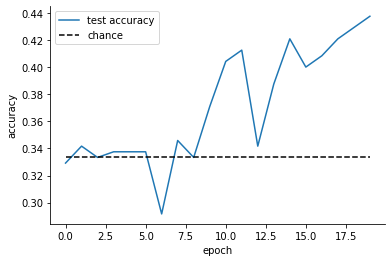

In [30]:
# テストデータの判定精度を可視化
plt.plot(range(numEpoch),acc_te,label='test accuracy')
plt.plot(range(numEpoch),np.ones(numEpoch)/3,c='k',linestyle='dashed',label='chance')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

### 運営が用意したほかのデータセット
##### 希望者のみダウンロードしてください．
##### [おにいちゃんCD](https://www.amazon.co.jp/%E3%81%8A%E3%81%AB%E3%81%84%E3%81%A1%E3%82%83%E3%82%93CD-1200%E3%81%AE%E3%80%8C%E3%81%8A%E3%81%AB%E3%81%84%E3%81%A1%E3%82%83%E3%82%93%E3%80%8D%E3%81%8C%E8%81%9E%E3%81%91%E3%82%8BCD-%E7%99%BD%E9%9B%AA%E3%81%BF%E3%82%8B%E3%81%8F/dp/B000G5S7ZO)※閲覧注意かも？

In [ ]:
!mkdir $ROOT_DIR/cascaded-am-tuning-for-sound-recognition/Onii
%cd $ROOT_DIR/cascaded-am-tuning-for-sound-recognition/Onii
file_id = '1o4g-BImXIyEyeoN6qzg0WuLsnd2em2CN' #e.g. '1-76_xBMDJ1Cd65FnUOs3SK7gpiO6pnrS'
file_name = 'ノーマライズなし-20210313T030420Z-001.zip' #e.g. 'train-clean-360.tar'
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={file_id}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={file_id}" -O {file_name} && rm -rf /tmp/cookies.txt
!unzip <ARCHIVE_FILE_NAME> -C <PATH_TO_EXTRACT_TO>
%cd $ROOT_DIR

/content/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/Onii
--2021-03-13 03:23:33--  https://docs.google.com/uc?export=download&confirm=TQGR&id=1o4g-BImXIyEyeoN6qzg0WuLsnd2em2CN
Resolving docs.google.com (docs.google.com)... 216.58.192.110, 2607:f8b0:4026:802::200e
Connecting to docs.google.com (docs.google.com)|216.58.192.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-6k-docs.googleusercontent.com/docs/securesc/ugo3dptuu1jfl4l2og6vd1j8l4jeeife/pom64atc36o8hkql1v8qq6almfbg0fgt/1615605750000/06217716492365706553/15229567820441528443Z/1o4g-BImXIyEyeoN6qzg0WuLsnd2em2CN?e=download [following]
--2021-03-13 03:23:33--  https://doc-0s-6k-docs.googleusercontent.com/docs/securesc/ugo3dptuu1jfl4l2og6vd1j8l4jeeife/pom64atc36o8hkql1v8qq6almfbg0fgt/1615605750000/06217716492365706553/15229567820441528443Z/1o4g-BImXIyEyeoN6qzg0WuLsnd2em2CN?e=download
Resolving do

# 学習したDNNの各ユニット特性を調べる
### DNNのユニットの特性を調べるために入力している波形を可視化
##### ホワイトノイズが様々な周波数のsin波を包絡線とするようにAmplitude Modulationされた波形

In [ ]:
waveFs = 44100 # <- ESC-50の場合．TIMITなら16000 Hz
trainingRms = 0.10315431641022865 #ESCの場合をべた書きしておいた
stimSec = 3

waveLen=int(stimSec*waveFs)
times=np.arange(waveLen)/waveFs
freqs=np.logspace(np.log10(1), np.log10(2000), 2**8) # 1 Hzから2000 Hzまで指数間隔でAM
freq = freqs[0]  

waves=np.random.randn(2**8, waveLen) # ベースとなるホワイトノイズを生成
for i, freq in enumerate(freqs):
  waves[i,:]*=(1-np.cos(freq*2*np.pi*times)) # AM変調させている
waves=scaleRms(waves, trainingRms)

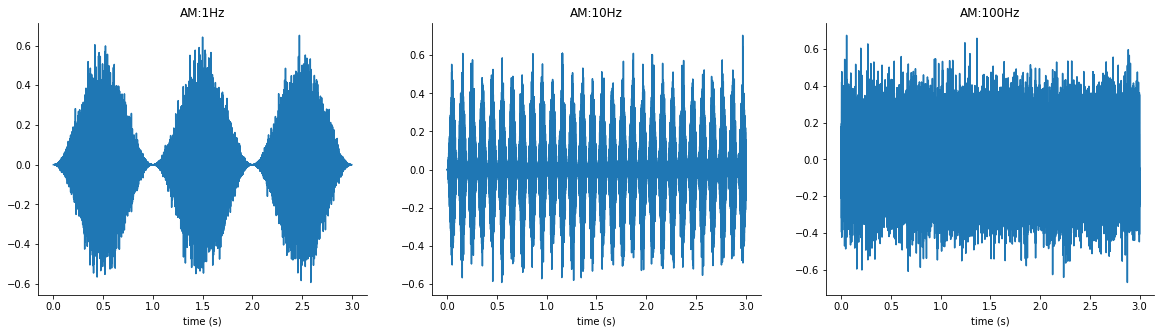

In [ ]:
idx_10Hz = int(255/np.log10(2000)) # 指数間隔で調べるAM周波数を増やしているので
idx_100Hz = int(255*2/np.log10(2000))

### 波形を可視化
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(times,waves[0,:])
ax1.set_xlabel('time (s)')
ax1.set_title('AM:1Hz')
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(times,waves[idx_10Hz,:])
ax2.set_xlabel('time (s)')
ax2.set_title('AM:10Hz')
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(times,waves[idx_100Hz,:])
ax3.set_xlabel('time (s)')
ax3.set_title('AM:100Hz')
plt.show()

In [ ]:
#音にしてみると
import IPython.display
print('10Hz')
IPython.display.Audio(waves[idx_10Hz, :], rate=waveFs)

10Hz


##### 【課題設定のヒント】（上級者向け？）
調べる波形をwhite noiseのAM波形以外にもsin波のAM波形や純粋なsin波を試す

### DNNの生理学的解析
各層のユニット（128個）がAM波形を処理していく過程（activation値）を保存することで動物のユニット記録を模している．

In [ ]:
# ESC50またはTIMITで調べる場合，
def recording(dataset='ESC50', idx=0, stimsec=2):
  dirRoot=Path("./cascaded-am-tuning-for-sound-recognition")
  gpu_id=0

  dirEsc=dirRoot/"{}".format(dataset)
  fileInfo=dirEsc/"info.txt"
  dirSound=dirEsc/"ESC-50" if dataset=='ESC50' else dirEsc/"{}".format(dataset)
### 検査波形の規格化のためにRMSを計算 ###
  if dataset=='ESC50':
    from training.esc50.train_eval import compTrainingRms
    infos=readInfos(str(fileInfo))
    waves, waveFs=loadWaves(str(dirSound), infos)
    waves=fade(waves, waveFs)
    trainingRms=compTrainingRms(waves, infos) # 訓練データのRMS
  else:
    from training.timit.load_data import loadData
    from training.timit.train_eval import compTrainingRms
    infos, waves, trues, labels, waveFs=loadData(dirSound)
    trainingRms=compTrainingRms(waves, infos) # 訓練データのRMS

  dirResult=dirEsc/"Results"/"Result{}".format(idx)
### モデルのarchitectureディレクトリを指定 ###
  fileArchitecture=dirResult/"Architecture.txt"
  architecture=readArchitecture(fileArchitecture)
### モデルの重みディレクトリを指定 ###
  fileModel=dirResult/"TrainedModel"
### 検査波形の時間(s)を指定．1～3秒推奨．1秒以下だと2000 Hzまで調べられない．3秒を超えるとメモリクラッシュしやすい ###
  stimSec=stimsec 

  dirResponse=dirResult/"Response"
  dirResponse.mkdir(exist_ok=True, parents=True)

### 256通りのAM波形の反応を調べて保存する ###
  response=compNoiseAmAveSyn(stimSec, waveFs, fileModel, architecture, gpu_id, trainingRms) 
  fileResponse=dirResponse/"Am"
  with open(fileResponse, "wb") as f: pickle.dump(response, f)

### Am0はAmplitude Modulationを行わない単なるホワイトノイズを入力（コントロールとして） ###
  response=compNoiseAm0AveSyn(stimSec, waveFs, fileModel, architecture, gpu_id, trainingRms)
  fileResponse=dirResponse/"Am0"
  with open(fileResponse, "wb") as f: pickle.dump(response, f)
  return direResponse

In [ ]:
dataset = 'TIMIT' # TIMITのほうがサンプリング周波数が低いので計算が早い
idx = 0 # 学習済みモデルが39個用意されている．好きな番号を入力 idx=11が一番きれいかもしれない
recording(dataset=dataset, stimsec=2) #recording開始．30分程度かかる．
RESPONSE_DIR = SAVE_DIR + '/{}/Results/Result{}/Response'.format(dataset,idx)
if not os.path.isdir(RESPONSE_DIR):
  os.makedirs(RESPONSE_DIR)
!cp dirResponse/"Am" RESPOMSE_DIR
!cp dirResponse/"Am0" RESPOMSE_DIR # 自身のGoogle DirveにDNNのユニットの反応を保存

Conducting physiology: stimulus AM freq: 1.0
Conducting physiology: stimulus AM freq: 1.0302561499812346
Conducting physiology: stimulus AM freq: 1.061427734574156
Conducting physiology: stimulus AM freq: 1.0935424513056737
Conducting physiology: stimulus AM freq: 1.126628835723225
Conducting physiology: stimulus AM freq: 1.1607162867500505
Conducting physiology: stimulus AM freq: 1.1958350928076216
Conducting physiology: stimulus AM freq: 1.2320164587284326
Conducting physiology: stimulus AM freq: 1.2692925334830694
Conducting physiology: stimulus AM freq: 1.3076964387461945
Conducting physiology: stimulus AM freq: 1.3472622983268254
Conducting physiology: stimulus AM freq: 1.3880252684890646
Conducting physiology: stimulus AM freq: 1.4300215691902132
Conducting physiology: stimulus AM freq: 1.4732885162640326
Conducting physiology: stimulus AM freq: 1.5178645545777476
Conducting physiology: stimulus AM freq: 1.5637892921922516
Conducting physiology: stimulus AM freq: 1.61110353555586

KeyboardInterrupt: ignored

### 独自のデータセットの場合，訓練データのRMSでユニットの検査波形を正規化する必要がある．
##### ※RMS = Root Mean Square．振幅の平均的な大きさ．

In [ ]:
def TrainingRms(waves):
  rms=[]
  for i in range(len(waves)):
   wave=waves[i]
   rms.append((wave**2).mean()**0.5)
  return np.array(rms).mean()

def my_recording(dataset='VoiceActor', stimsec=2):
  
  gpu_id=0
  dirResult = Path(SAVE_DIR+"/{}/Results".format(dataset))
  
  fileArchitecture=dirResult/"Architecture.txt"
  architecture=readArchitecture(fileArchitecture)
  
  fileModel=dirResult/"TrainedModel"
  stimSec=stimsec

  dirResponse=dirResult/"Response"
  dirResponse.mkdir(exist_ok=True, parents=True)
  
  waves, waveFs = my_load_waves(dataset='VoiceActor',n_train=30, numLabel=3)
  trainingRms = TrainingRms(waves)

  response=compNoiseAmAveSyn(stimSec, waveFs, fileModel, architecture, gpu_id, trainingRms)
  fileResponse=dirResponse/"Am"
  with open(fileResponse, "wb") as f: pickle.dump(response, f)

  response=compNoiseAm0AveSyn(stimSec, waveFs, fileModel, architecture, gpu_id, trainingRms)
  fileResponse=dirResponse/"Am0"
  with open(fileResponse, "wb") as f: pickle.dump(response, f)
  return direResponse

def my_load_waves(dataset='VoiceActor',n_train=30, numLabel=3):
  if dataset=='VoiceActor':
    dataDir = ROOT_DIR+"/cascaded-am-tuning-for-sound-recognition/VoiceActor"
    waves=[None]*n_train*numLabel
    labels = ['normal', 'happy', 'angry']
  for li in range(numLabel):
    for ind in list(range(n_train)):
      waves[n_train*li+ind],fs = soundfile.read(dataDir+'/tsuchiya_'+labels[li]+'/tsuchiya_'+labels[li]+'_'+str(ind+1).zfill(3)+'.wav') #tsuchiya_happy_003などを読み込む     
  return waves, fs

In [ ]:
dataset = "VoiceActor"
my_recording(dataset=dataset, stimsec=2)

Conducting physiology: stimulus AM freq: 1.0
Conducting physiology: stimulus AM freq: 1.0302561499812346
Conducting physiology: stimulus AM freq: 1.061427734574156


KeyboardInterrupt: ignored

# 可視化のための関数の紹介
### 最も活性化する周波数でソート：sort_mtfで計算し，draw_mtfで描画

<img src="https://drive.google.com/uc?export=view&id=1h3L7ovZQS2GQJYeLfNWNx30OSu0L4mZh" alt="Drawing" width="700">

In [ ]:
def sort_mtf(dataset='ESC50', idx=11):
  dirRoot=Path("./cascaded-am-tuning-for-sound-recognition")

  dirEsc=dirRoot/"{}".format(dataset)
  dirResult=dirEsc/"Results"/"Result{}".format(idx)
  dirFigure=dirResult/"Figure"

  dirResponse=dirResult/"Response"
  fileResponse=dirResponse/"Am"
  with open(fileResponse, "rb") as f: response=pickle.load(f)

  numLayer=response.shape[-2]
  numChannel=response.shape[-1]

  cm=plt.get_cmap("viridis")
  gray=np.array((127,127,127,255), uint8)
  for tyi,ty in enumerate(("rate","temp")):
    for li in range(numLayer):
      r=response[...,tyi,li,:] # 第li層のactivation値を取得

      validIndex=(~(np.isnan(r)|(r==0))).any(axis=0)
      rValid=r[:,validIndex]
      rValid=rValid[:,np.nanargmax(rValid, axis=0).argsort()]#最適周波数でソート

      rValid/=np.nanmax(rValid, axis=0)
      mi=0
      ma=1

      r=np.concatenate((rValid, r[:,~validIndex]), axis=1)

      im=(cm((r.T-mi)/(ma-mi))*255).astype(uint8)
      im=im.reshape(r.size, im.shape[-1])
      im[np.isnan(r).reshape(r.size),:]=gray
      im=im.reshape(r.shape[1],r.shape[0],im.shape[-1])
      im=np.flipud(im)
      fileFig=dirFigure/"Mtf"/(ty+"_layer"+str(li)+".png")
      fileFig.parent.mkdir(exist_ok=True, parents=True)
      with open(fileFig, "wb") as f: Image.fromarray(im).save(fileFig)#カラーマップを保存
  return dirFigure

In [ ]:
def draw_mtf(dirFigure):
  tMTF = [None]*numLayer
  rMTF = [None]*numLayer
  plt.figure(figsize=(10, 20))
  for i in range(numLayer):
    tMTF[i] = Image.open(dirFigure/"Mtf/temp_layer{}.png".format(i))
    rMTF[i] = Image.open(dirFigure/"Mtf/rate_layer{}.png".format(i))
    plt.subplot(numLayer, 2, numLayer*2-2*i-1)
    plt.imshow(tMTF[i])
    plt.xticks([0,255/np.log10(2000),255*np.log10(100)/np.log10(2000),255*np.log10(1000)/np.log10(2000)], labels=[1,10,100,1000] if i==0 else [])
    plt.ylabel('L{}\n Unit #'.format(i+1))
    plt.yticks([0,63,127],labels=[128,64,1])
    if i==0: plt.xlabel('Frequency (Hz)')
    if i==12: plt.title('tMTF')

    plt.subplot(numLayer, 2, numLayer*2-2*i)
    plt.imshow(rMTF[i])
    plt.xticks([0,255/np.log10(2000),255*np.log10(100)/np.log10(2000),255*np.log10(1000)/np.log10(2000)], labels=[1,10,100,1000] if i==0 else [])
    plt.yticks([0,63,127],labels=[])
    if i==0: plt.xlabel('Frequency (Hz)')
    if i==12: plt.title('rMTF')
  plt.subplots_adjust(wspace=-0.5, hspace=0.2)
  plt.show()

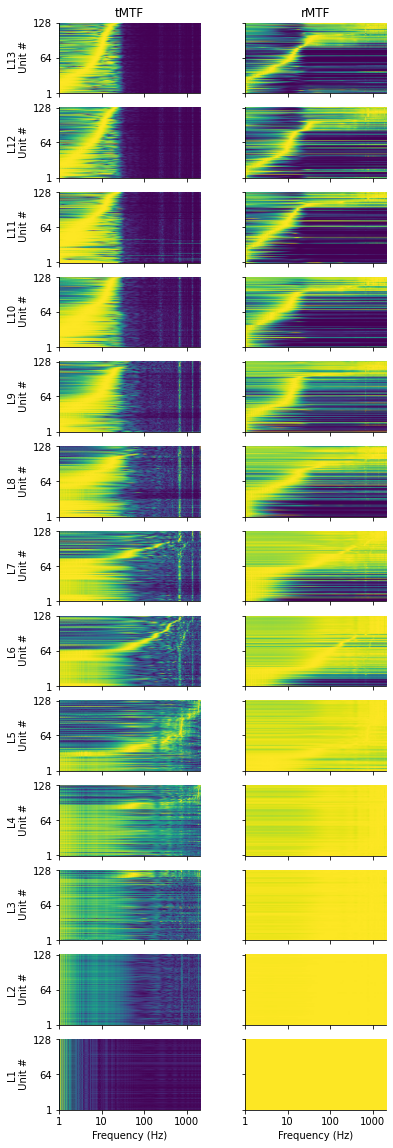

In [ ]:
dirFigure = sort_mtf(dataset='ESC50', idx=11)
draw_mtf(dirFigure)

### 最適変調周波数（BMF）と上界カットオフ周波数（UCF）の階層性を調べる：plot_bmf_ucf
<img src="https://drive.google.com/uc?export=view&id=1ex8FRJThxN73YDdYGGPFVub4xIDJ19Dp" alt="Drawing" width="700">


In [ ]:
from utils.utils import defaultColors
from physiology.mtf_plot import compFilterType, bmf, cutoff

def plot_bmf_ucf(dataset='ESC50', idx=11):
  dirRoot=Path("./cascaded-am-tuning-for-sound-recognition")

  dirEsc=dirRoot/"{}".format(dataset)
  dirResult=dirEsc/"Results"/"Result{}".format(idx)

  dirResponse=dirResult/"Response"
  dirResponse.mkdir(exist_ok=True, parents=True)
  fileResponse=dirResponse/"Am"
  with open(fileResponse, "rb") as f: response=pickle.load(f)
  fileResponse=dirResponse/"Am0"
  with open(fileResponse, "rb") as f: response0Ave, response0Syn=pickle.load(f)

  freqs=np.logspace(np.log10(1), np.log10(2000), 2**8)
  numLayer=response.shape[-2]
  numChannel=response.shape[-1]
  assert response0Ave.shape[-2]==numLayer
  assert response0Ave.shape[-1]==numChannel

  response[:,1][response[:,1]<0.01]=np.NaN
  response[:,0][response[:,0]<response0Ave+0.01]=np.NaN
  filtType=compFilterType(response)

  print('type','layer','N_bp', 'N_lp+N_bp',sep="\t")
  binWidth=0.2
  histograms={}
  for tyi,ty in enumerate(("ave","syn")):
    bestFreqs=bmf(response[...,tyi,:,:], freqs, True)
    cutoffs=cutoff(response[...,tyi,:,:], freqs, lambda rch: np.nanmax(rch)*0.8, True)
    for li in range(numLayer):
      ### 有意なBMFを検出 ###
      f=bestFreqs[li]
      f[np.logical_or(filtType[tyi,li]==0,filtType[tyi,li]==3,filtType[tyi,li]==1)]=np.NaN
      f=f[~np.isnan(f)]
      if len(f)>0 and f.ptp()>0: histograms[tyi,0,li]=calcHist(f)
      sumBest=len(f) # BMFの個数
      ### 有意なUCFを検出 ###
      f=cutoffs[li]
      f[np.logical_or(filtType[tyi,li]==1,filtType[tyi,li]==3)]=np.NaN
      f=f[~np.isnan(f)]
      if len(f)>0 and f.ptp()>0: histograms[tyi,1,li]=calcHist(f)
      sumCut=len(f) # UCFの個数
      print(ty,li,sumBest,sumCut,sep="\t")

### 以下カラーマップの保存と可視化 ###
  grid=GridSpec(numLayer,2)
  # 	if len([h.max() for h,b in histograms.values()])==0: return
  ma=max([h.max() for h,b in histograms.values()])
  print("hist max", ma)
  ma=58
  binMin=min([b.min() for h,b in histograms.values()])
  binMax=max([b.max() for h,b in histograms.values()])
  print("bin min", binMin, "bin max", binMax)
  binMin=-0.0365397864987
  binMax=3.39000592068
  plt.figure(figsize=(4,14))
  for tyi,ty in enumerate(("rate","temp")):
    for li in range(numLayer):
  # 			sp=plt.subplot(grid[numLayer-1-li,tyi])
      sp=plt.subplot(grid[numLayer-1-li,1-tyi])
      sp.set_title(ty+" "+str(li))
      if (tyi,1,li) in histograms:
        hist,bins=histograms[tyi,1,li]
        sp.bar((bins[1:]+bins[:-1])/2, hist, np.diff(bins), edgecolor=defaultColors(1), facecolor=defaultColors(1,0.3))
      if (tyi,0,li) in histograms:
        hist,bins=histograms[tyi,0,li]
        sp.bar((bins[1:]+bins[:-1])/2, hist, np.diff(bins), edgecolor=defaultColors(0), facecolor=defaultColors(0,0.3))
      sp.set_xlim(binMin-0.1,binMax+0.1)
      sp.set_ylim(0,ma*1.05)
      sp.set_xticks((0,1,2,3))
      sp.tick_params(color=(0.5,0.5,0.5), which="both", direction="in", labelcolor=(0.5,0.5,0.5), width=1)
      for spine in sp.spines: sp.spines[spine].set_color((0.5,0.5,0.5))
  plt.tight_layout(pad=0.5)
  plt.show()

def calcHist(f):
  binWidth=0.2
  lf=np.log10(f)
  numBin=int(np.ceil(lf.ptp()/binWidth))
  m=(lf.min()+lf.max())/2
  bi=np.linspace(m-binWidth*numBin/2,m+binWidth*numBin/2, numBin+1)
  hist,bi=np.histogram(lf, bi)
  return hist,bi

/content/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/physiology/mtf_plot.py:25: RuntimeWarning: All-NaN slice encountered
  ptp=np.nanmax(r)-np.nanmin(r)


type	layer	N_bp	N_lp+N_bp
ave	0	0	0
ave	1	0	0
ave	2	0	0
ave	3	0	0
ave	4	0	3
ave	5	10	31
ave	6	3	28
ave	7	30	54
ave	8	46	63
ave	9	52	77
ave	10	51	76
ave	11	62	76
ave	12	50	68
syn	0	0	0
syn	1	0	0
syn	2	38	51
syn	3	34	82
syn	4	89	110
syn	5	63	128
syn	6	51	128
syn	7	40	128
syn	8	65	127
syn	9	56	128
syn	10	38	127
syn	11	76	128
syn	12	80	128
hist max 58
bin min -0.0365397864987389 bin max 3.390005920684569


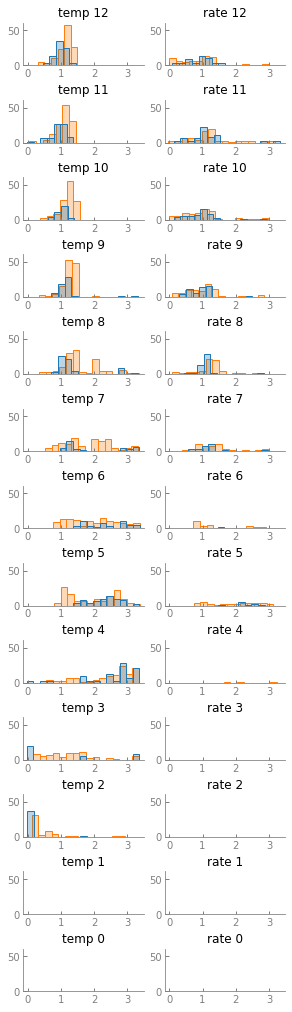

In [ ]:
plot_bmf_ucf(dataset='ESC50', idx=11)

### 脳の階層性との類似度を調べる：draw_similarity

In [ ]:
from physiology.mtf_analysis import compLayerMeasure, compRegionLayerSimilarity
from physiology.am_meta_analysis import readCumulative

def draw_similarity(dataset='ESC50', idx=11):
  dirRoot=Path("./cascaded-am-tuning-for-sound-recognition")

  dirCumulatives=dirRoot/"am-meta-analysis"/"cumulative" #脳のデータのディレクトリ
  dirEsc=dirRoot/"{}".format(dataset)
  dirResult=dirEsc/"Results"/"Result{}".format(idx)

  dirResponse=dirResult/"Response"
  fileResponse=dirResponse/"Am"
  with open(fileResponse, "rb") as f: response=pickle.load(f)
  fileResponse=dirResponse/"Am0"
  with open(fileResponse, "rb") as f: response0Rate,response0Temp=pickle.load(f)

  regions=("AN","CN","SOC","NLL", "IC", "MGB","cortex")

  numLayer=response.shape[-2]
  numChannel=response.shape[-1]

  layerMeasures=compLayerMeasure(response, response0Rate)
  cumulatives=readCumulative([file for file in layerMeasures.keys() if "-" not in file], str(dirCumulatives))
  similarity=compRegionLayerSimilarity(layerMeasures, cumulatives, numLayer, regions, numChannel) #各layerの各脳領域との相関を計算

# 可視化部分
  plt.pcolormesh(similarity, cmap="inferno")
  plt.yticks(np.arange(len(regions))+0.5,regions)
  plt.xticks(np.arange(numLayer)+0.5, np.arange(numLayer)+1)
  plt.ylabel("Brain regions")
  plt.xlabel("DNN layers")
  plt.show()

/content/cascaded-am-tuning-for-sound-recognition/cascaded-am-tuning-for-sound-recognition/physiology/mtf_analysis.py:114: RuntimeWarning: All-NaN slice encountered
  ptp=np.nanmax(r)-np.nanmin(r)


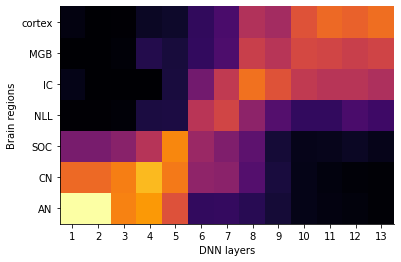

In [ ]:
draw_similarity(dataset='ESC50', idx=11)

# 数時間計算するときの注意事項
- Google Colabratoryには90分ルールと12時間ルールがあります（厳密な時間は非公開）
1. 90分：何もアクションを起こさないと接続が切れ，メモリが消える（ストレージは残っているはず）
  - 30分くらいおきにColab画面でマウスを動かす，セルを追加したり削除したり何かしらアクションを起こす
  - Chromeの拡張機能[Easy Auto Refresh](https://chrome.google.com/webstore/detail/easy-auto-refresh/aabcgdmkeabbnleenpncegpcngjpnjkc/related?hl=ja)が便利．リロード時間を30分とかに設定し，1回目のリロードだけはポップアップに対して再読み込みを選択する必要があるとのこと．
  - MacやLinuxならopen関数にcolabのURLを指定してシェルスクリプトを[参考](https://qiita.com/enmaru/items/2770df602dd7778d4ce6)，Windowsならopenの代わりにstartでバッチファイルを作成すれば対策できる（かもしれない．試していない）
1. 12時間：GPUインスタンスは12時間以上連続で使用できない
  - 主要なResult（学習後の重みやrecordingのresponse）を個人のGoogle Driveに保存．このノートブックでは主要なデータはそのように保存している（なので各自のドライブにSpcamp21のフォルダが勝手にできてしまいますがご了承ください）．


In [8]:
inputlen = np.array([i[1] - 1 for i in trained_net.sturcture]).sum() + 1
test_waves = np.random.randn(10,inputlen)

NameError: ignored

In [10]:
test_waves = np.random.randn(10,8192)